# 1. 本文概述

本文实现了三个不同版本的 Mixture of Experts 模型，分别是最基础版本的 MoE（主要是为了理解 MoE 的基本原理）、Sparse MoE（大模型训练使用的基础版本）和 Deepseek 用的 SharedExpert MoE。

MoE 网络中包含多个 Experts，这个 Expert 一般是一个 FeedForward Network(FFN)。

In [2]:
# 导入基本模块
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
# Expert Model
class BasicExpert(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)
    
    def forward(self, x):
        return self.linear(x)

## 2. 基础版本 MoE

In [4]:
class BasicMoE(nn.Module):
    def __init__(self, in_dim, out_dim, num_experts):
        super().__init__()
        self.experts = nn.ModuleList([BasicExpert(in_dim, out_dim) for _ in range(num_experts)])
        self.gate = nn.Linear(in_dim, num_experts)

    def forward(self, x):
        gates = torch.softmax(self.gate(x), dim=-1)  # (batch_size, num_experts) 每个样本的 experts 权重
        expert_outs = torch.cat([expert(x).unsqueeze(1) for expert in self.experts], dim=1)
        return torch.sum(gates.unsqueeze(-1) * expert_outs, dim=1)


def test_basic_moe():
    model = BasicMoE(in_dim=4, out_dim=6, num_experts=3)
    x = torch.randn(4, 4)
    out = model(x)
    print(out)

test_basic_moe()

tensor([[-0.1026,  0.3825, -0.1686,  0.0659,  0.0834,  0.2812],
        [-0.1002,  0.1845,  0.0657, -0.3885,  0.0059,  0.3821],
        [ 0.1400,  0.8646, -0.1015, -0.0725,  0.1338,  0.4425],
        [-0.3135,  0.5524, -0.1161,  0.2923,  0.1513,  0.3765]],
       grad_fn=<SumBackward1>)


# 3. Sparse MoE
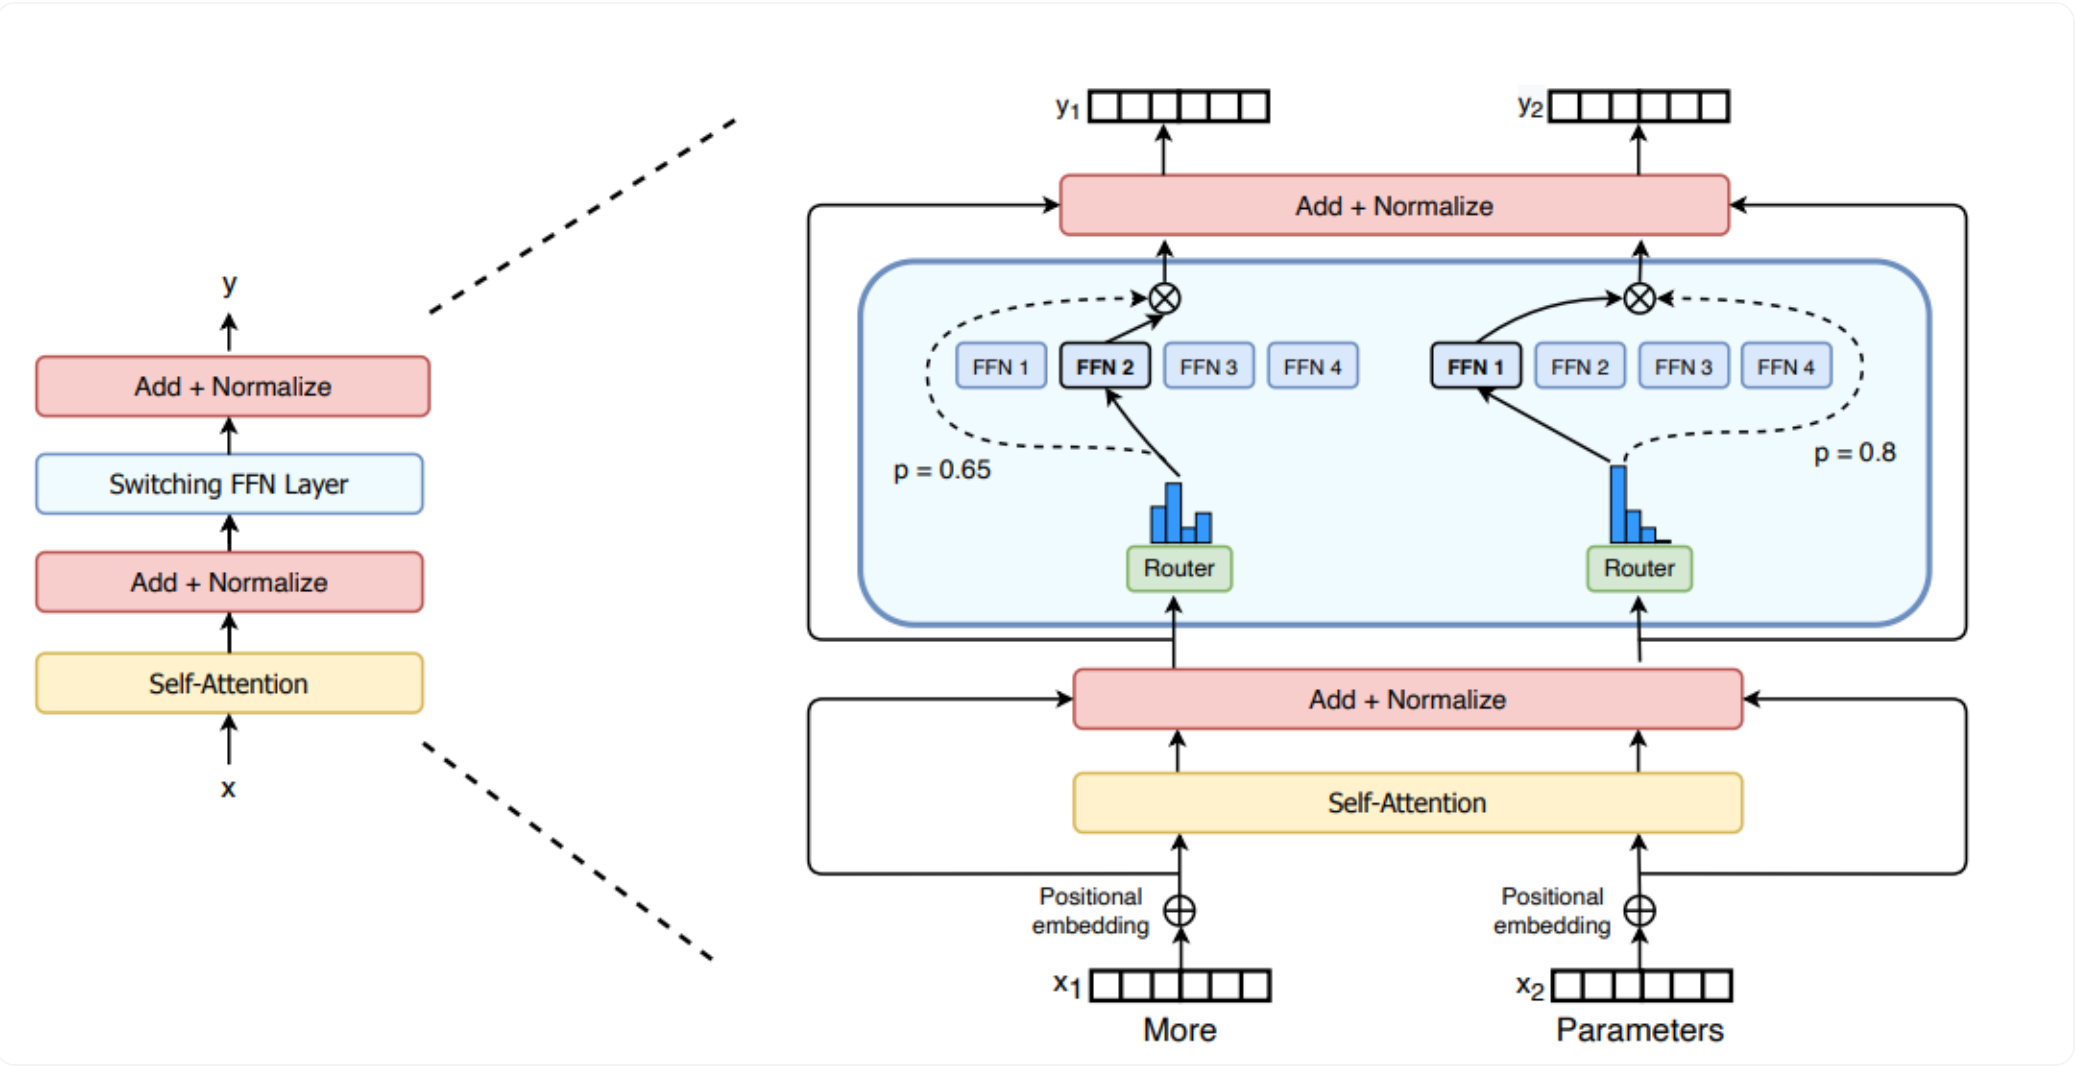

In [10]:
class MoERouter(nn.Module):
    def __init__(self, hidden_dim, num_experts, top_k=3, eps=1e-6):
        super().__init__()
        self.gate = nn.Linear(hidden_dim, num_experts)
        self.num_experts = num_experts
        self.top_k = top_k
        self.eps = eps  # 防止除以零的小量

    def forward(self, x):
        router_probs = F.softmax(self.gate(x), dim=-1)

        top_k_probs, top_k_indices = torch.topk(router_probs, self.top_k, dim=-1)  # 选取 top-k 专家
        top_k_weights = top_k_probs / (top_k_probs.sum(dim=-1, keepdim=True) + self.eps)  # 归一化权重（数值稳定性优化）

        return top_k_weights, top_k_indices


class SparseMoE(nn.Module):
    """稀疏混合专家模块"""
    def __init__(self, hidden_dim, num_experts, top_k=4):
        super().__init__()
        self.router = MoERouter(hidden_dim, num_experts, top_k)
        self.experts = nn.ModuleList([BasicExpert(hidden_dim, hidden_dim) for _ in range(num_experts)])
        self.num_experts = num_experts
        self.top_k = top_k

    def forward(self, x):
        batch_size, seq_len, hidden_dim = x.shape
        x_flat = x.view(-1, hidden_dim)  # (batch*seq, hidden_dim)

        top_k_weights, top_k_indices = self.router(x_flat)

        moe_output = torch.zeros_like(x_flat)  # 初始化输出张量

        # 遍历每个 top-k 专家
        for i in range(self.top_k):
            # 获取 top-i 专家对应的索引和权重
            expert_idx = top_k_indices[:, i]  # (batch*seq,)
            weight = top_k_weights[:, i].unsqueeze(1)  # (batch*seq, 1)

            # 选择对应的专家输出
            selected_input = torch.zeros_like(x_flat)
            for idx, expert in enumerate(self.experts):
                mask = (expert_idx == idx).float().unsqueeze(1)  # (batch*seq, 1)
                selected_input += mask * expert(x_flat)

            moe_output += weight * selected_input

        moe_output = moe_output.view(batch_size, seq_len, hidden_dim)

        return moe_output


def test_sparse_moe():
    model = SparseMoE(hidden_dim=4, num_experts=16, top_k=2)
    x = torch.randn(8, 512, 4)
    out = model(x)
    print(out.size())


test_sparse_moe()


torch.Size([8, 512, 4])


# 4. Deepseek MoE

> 这里的实现参考了 Deepseek MoE 的思想，有一定的简化，但是基本思想是一致的，主要是为了理解 SharedExpert MoE 的基本原理。

与 Sparse MoE 不同，Deepseek MoE 引入了一些始终存在的共享 Expert。这些共享 Expert 会处理所有的 token，而不是像 Sparse MoE 那样根据 token 动态选择 Expert。Deepseek MoE 模块的输出是 Shared Expert 的输出和 Routed Expert 输出的和。

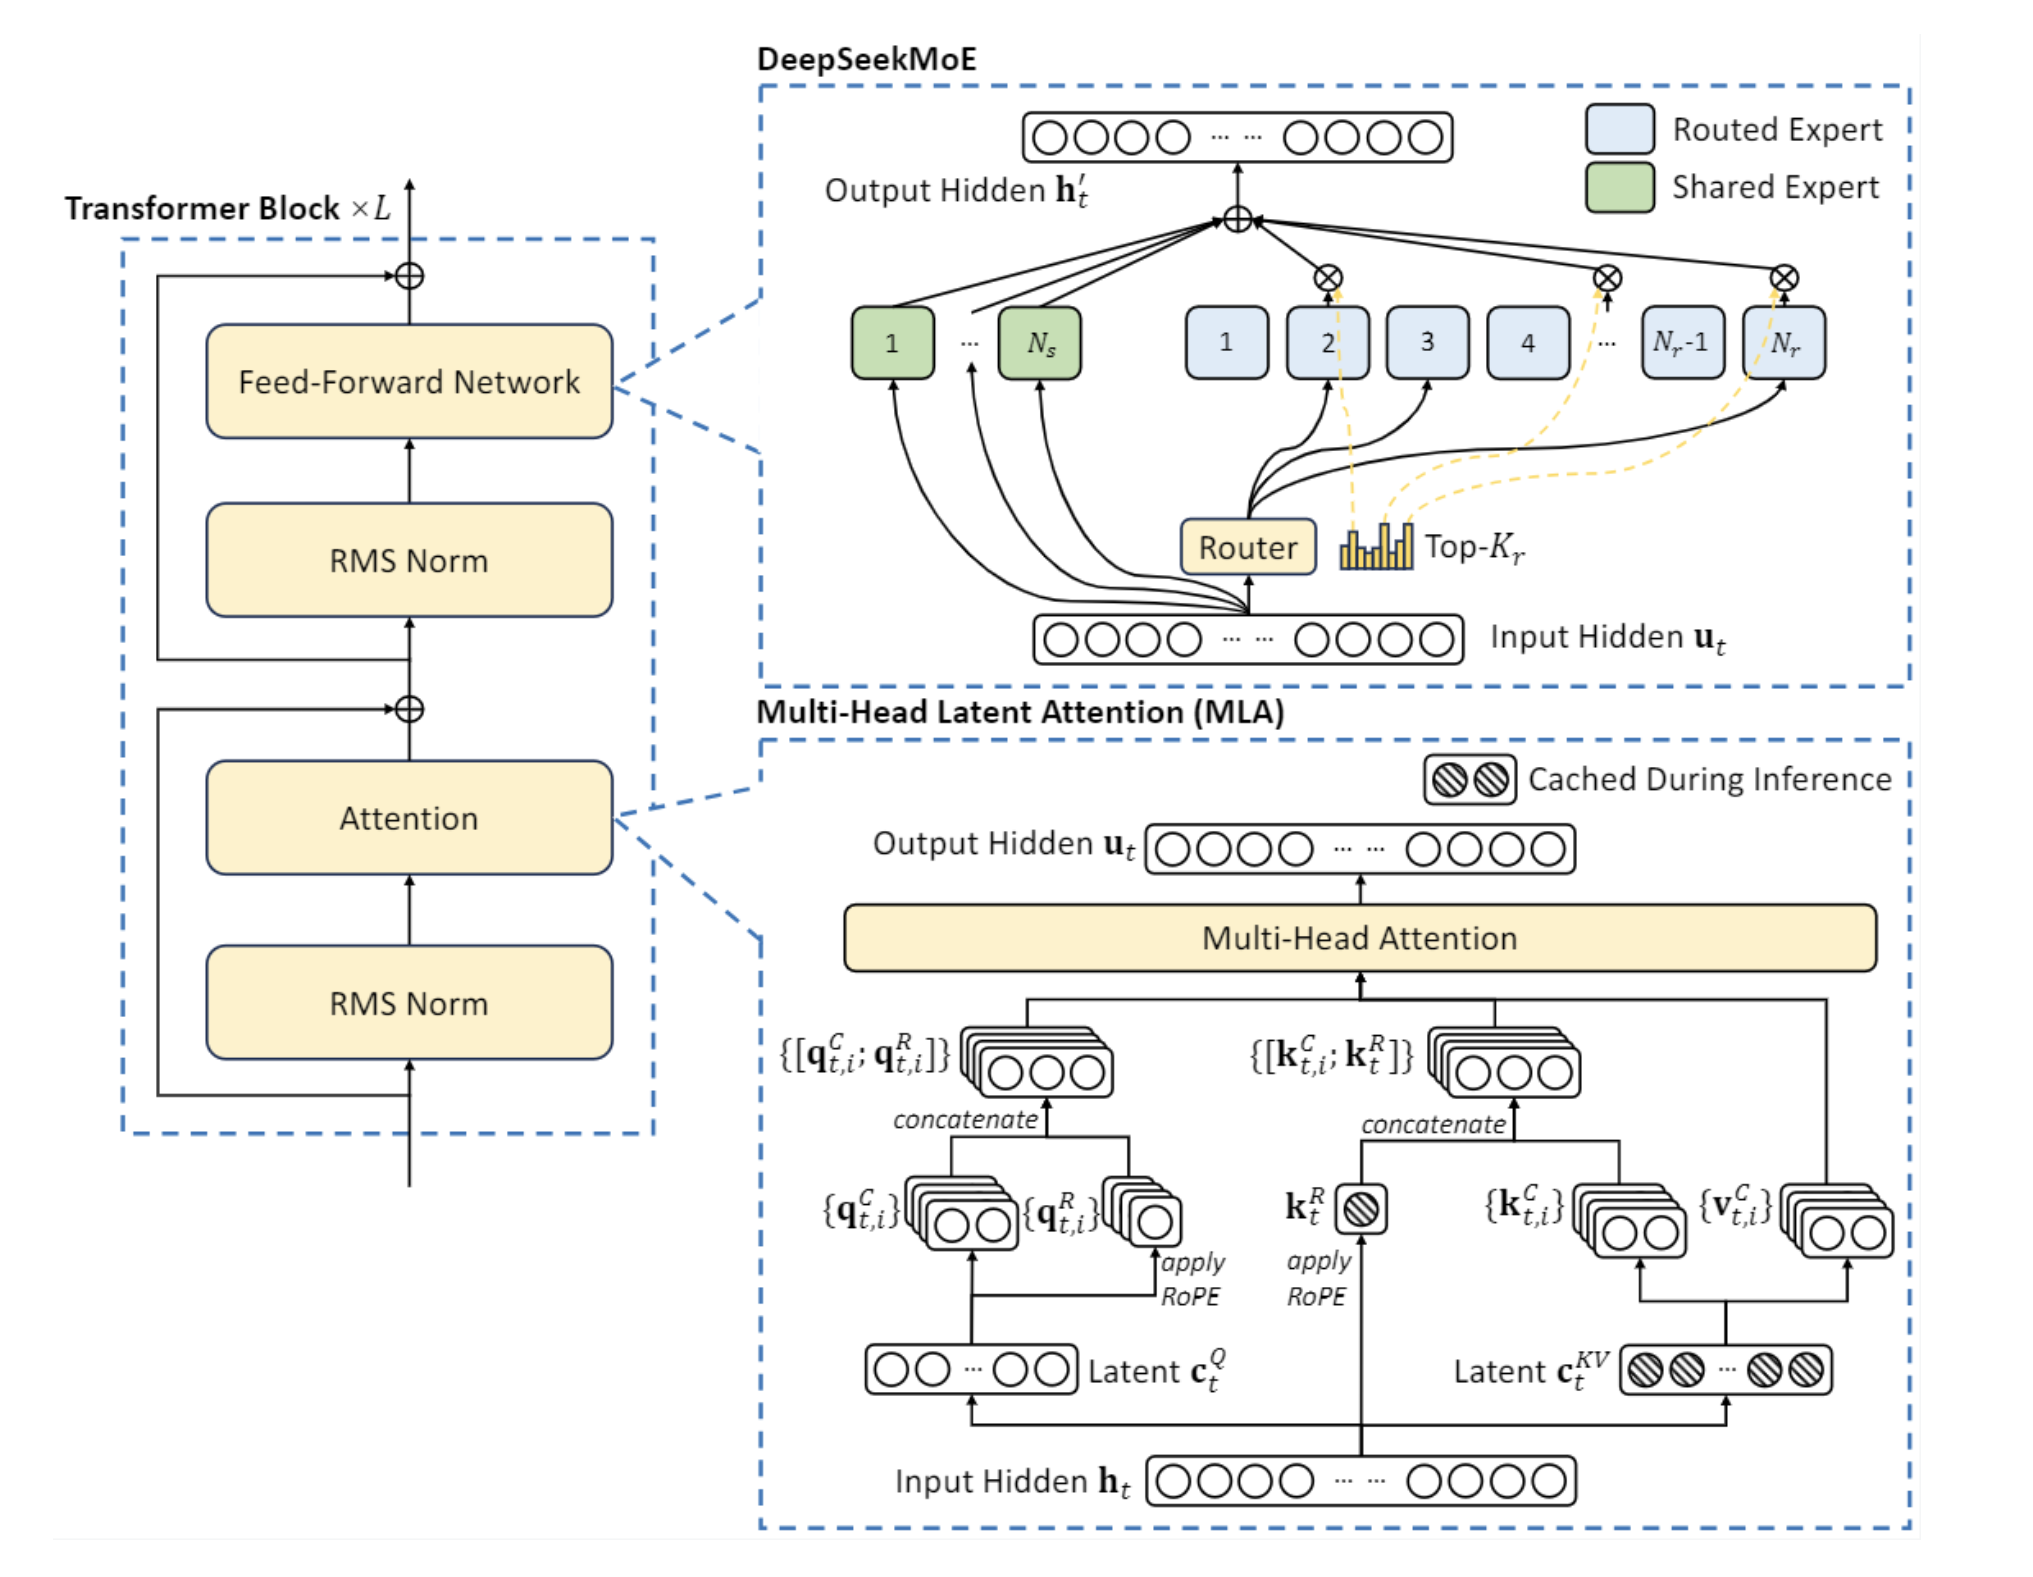

In [28]:
class DeepseekMoE(nn.Module):
    def __init__(self, hidden_dim, num_shared_experts, num_router_experts, top_k=4):
        super().__init__()
        self.shared_experts = nn.ModuleList([BasicExpert(hidden_dim, hidden_dim) for _ in range(num_shared_experts)])
        self.sparse_moe = SparseMoE(hidden_dim, num_router_experts, top_k)
    
    def forward(self, x):
        router_out = self.sparse_moe(x)
        shared_out = torch.stack([expert(x) for expert in self.shared_experts], dim=-1)
        shared_out = shared_out.sum(dim=-1)
        return router_out + shared_out
    
def test_deepseek_moe():
    model = DeepseekMoE(hidden_dim=4, num_shared_experts=8, num_router_experts=16, top_k=2)
    x = torch.randn(8, 512, 4)
    out = model(x)
    print(out.size())


test_deepseek_moe()


torch.Size([8, 512, 4])
